Importar librerías necesarias

In [17]:
# Importación de librerías
import pandas as pd
from pathlib import Path
import os
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    classification_report, confusion_matrix,
    ConfusionMatrixDisplay, roc_auc_score,
    roc_curve, auc
)
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix


1 - Cargar y preparar los datos

In [5]:
# 1. Detectar carpeta actual y raíz del proyecto
current_dir = Path(os.getcwd())
project_root = current_dir.parent.parent
data_path = project_root / "data" / "raw" / "heart-disease-dataset.csv"

# 2. Cargar CSV
heart = pd.read_csv(data_path)

# 3. Limpiar columnas no deseadas
heart.drop(columns=['exercise_angina', 'oldpeak', 'st_slope'], inplace=True)

heart.head()

,age,sex,chest_pain_type,resting_bp_s,cholesterol,fasting_blood_sugar,resting_ecg,max_heart_rate,target
0,40.0,1.0,2.0,140.0,289.0,0.0,0.0,172.0,0.0
1,49.0,0.0,3.0,160.0,180.0,0.0,0.0,156.0,1.0
2,37.0,1.0,2.0,130.0,283.0,0.0,1.0,98.0,0.0
3,48.0,0.0,4.0,138.0,214.0,0.0,0.0,108.0,1.0
4,54.0,1.0,3.0,150.0,195.0,0.0,0.0,122.0,0.0


In [20]:
heart.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1190 entries, 0 to 1189
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   age                  1190 non-null   float64
 1   sex                  1190 non-null   float64
 2   chest_pain_type      1190 non-null   float64
 3   resting_bp_s         1190 non-null   float64
 4   cholesterol          1190 non-null   float64
 5   fasting_blood_sugar  1190 non-null   float64
 6   resting_ecg          1190 non-null   float64
 7   max_heart_rate       1190 non-null   float64
 8   target               1190 non-null   float64
dtypes: float64(9)
memory usage: 83.8 KB


2 - Preparación de datos Train y Test 

In [6]:
# Separar features y target
X = heart.drop('target', axis=1)
y = heart['target']

In [7]:
# Escalar datos y dividir en entrenamiento/test
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)


3 – Definir modelos y GridSearch

In [8]:
# Definir modelos a comparar y sus grids de hiperparámetros
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier

models_params = {
    "Random Forest": {
        "model": RandomForestClassifier(random_state=42),
        "params": {
            "n_estimators": [100, 200],
            "max_depth": [None, 10, 20],
            "min_samples_split": [2, 5]
        }
    },
    "AdaBoost": {
        "model": AdaBoostClassifier(random_state=42),
        "params": {
            "n_estimators": [50, 100],
            "learning_rate": [0.5, 1.0]
        }
    },
    "Gradient Boosting": {
        "model": GradientBoostingClassifier(random_state=42),
        "params": {
            "n_estimators": [100, 150],
            "learning_rate": [0.1, 0.05],
            "max_depth": [3, 5]
        }
    }
}


4 – Ejecutar GridSearch y guardar resultados

In [ ]:
# Entrenar y comparar modelos con GridSearchCV de forma robusta
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.metrics import confusion_matrix

rows = []

for name, mp in models_params.items():
    grid = GridSearchCV(mp["model"], mp["params"], cv=5, scoring='roc_auc', n_jobs=-1)
    grid.fit(X_train, y_train)

    y_pred = grid.predict(X_test)
    y_proba = grid.predict_proba(X_test)[:, 1]

    # Convertir temporalmente para la evaluación
    y_test_int = y_test.astype(int)
    y_pred_int = y_pred.astype(int)

    report = classification_report(y_test_int, y_pred_int, output_dict=True)

    # report = classification_report(y_test, y_pred, output_dict=True)

    # Print Matriz de confusión
    cm = confusion_matrix(y_test, y_pred)
    print(f"{name} → Matriz de confusión:")
    print(cm)

    # Acceder a métricas de la clase positiva (1), usando .get por seguridad
    class_1_metrics = report.get("1", {"precision": 0, "recall": 0, "f1-score": 0})
    
    rows.append({
        "Model": name,
        "ROC AUC": roc_auc_score(y_test, y_proba),
        "Accuracy": report["accuracy"],
        "Precision": class_1_metrics["precision"],
        "Recall": class_1_metrics["recall"],
        "F1-Score": class_1_metrics["f1-score"],
        "Best Params": grid.best_params_
    })

# Crear DataFrame con resultados
results_df = pd.DataFrame(rows)

# Asegurarse de que exista la carpeta 'results'
output_path = project_root / "results"
output_path.mkdir(parents=True, exist_ok=True)

# Guardar resultados
results_df.to_csv(output_path / "model_comparison_results.csv", index=False)
print("Archivo guardado en: results/model_comparison_results.csv")


Random Forest → Predicciones únicas: {0.0, 1.0}
Random Forest → Matriz de confusión:
[[ 97  10]
 [ 15 116]]
AdaBoost → Predicciones únicas: {0.0, 1.0}
AdaBoost → Matriz de confusión:
[[ 86  21]
 [ 22 109]]
Gradient Boosting → Predicciones únicas: {0.0, 1.0}
Gradient Boosting → Matriz de confusión:
[[ 91  16]
 [ 15 116]]
Archivo guardado en: results/model_comparison_results.csv


In [22]:
print(results_df)

               Model   ROC AUC  Accuracy  Precision    Recall  F1-Score  \
0      Random Forest  0.951594  0.894958   0.920635  0.885496  0.902724   
1           AdaBoost  0.880467  0.819328   0.838462  0.832061  0.835249   
2  Gradient Boosting  0.925091  0.869748   0.878788  0.885496  0.882129   

                                         Best Params  
0  {'max_depth': None, 'min_samples_split': 2, 'n...  
1        {'learning_rate': 0.5, 'n_estimators': 100}  
2  {'learning_rate': 0.1, 'max_depth': 5, 'n_esti...  


In [24]:
results_df

,Model,ROC AUC,Accuracy,Precision,Recall,F1-Score,Best Params
0,Random Forest,0.951594,0.894958,0.920635,0.885496,0.902724,"{'max_depth': None, 'min_samples_split': 2, 'n..."
1,AdaBoost,0.880467,0.819328,0.838462,0.832061,0.835249,"{'learning_rate': 0.5, 'n_estimators': 100}"
2,Gradient Boosting,0.925091,0.869748,0.878788,0.885496,0.882129,"{'learning_rate': 0.1, 'max_depth': 5, 'n_esti..."


5 – Matriz de Confusión

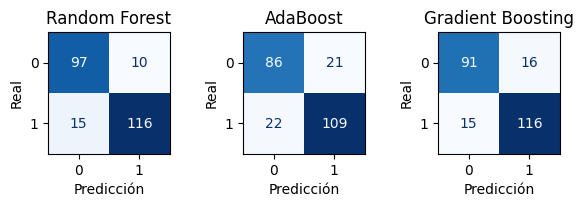

In [29]:
# Mostrar matrices de confusión para todos los modelos en una sola figura
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Crear figura con 1 fila y 3 columnas
fig, axes = plt.subplots(1, 3, figsize=(6, 2))

for ax, (name, mp) in zip(axes, models_params.items()):
    model = mp["model"].set_params(**rows[[r["Model"] for r in rows].index(name)]["Best Params"])
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
    disp.plot(ax=ax, cmap="Blues", colorbar=False)
    ax.set_title(name)
    ax.set_xlabel('Predicción')
    ax.set_ylabel('Real')

plt.tight_layout()
plt.show()


Visualización comparativa de métricas

In [35]:
# Seleccionar columnas relevantes
metrics_df = pd.DataFrame(rows)[['Model', 'Accuracy', 'Precision', 'Recall', 'F1-Score']]
metrics_df.set_index('Model', inplace=True)

# Función para resaltar el valor máximo en cada columna
def highlight_max(s):
    is_max = s == s.max()
    return ['background-color: darkblue' if v else '' for v in is_max]

# Mostrar con estilos
styled_table = metrics_df.style.apply(highlight_max, axis=0).format("{:.3f}")
styled_table

,Accuracy,Precision,Recall,F1-Score
Model,,,,
Random Forest,0.895,0.921,0.885,0.903
AdaBoost,0.819,0.838,0.832,0.835
Gradient Boosting,0.870,0.879,0.885,0.882


In [40]:
# Análisis automático del mejor modelo basado en métricas clave
import pandas as pd

# Crear DataFrame con resultados
df_metrics = pd.DataFrame(rows)

# Evaluar por F1-Score como métrica global de equilibrio entre precisión y recall
best_model = df_metrics.loc[df_metrics['F1-Score'].idxmax()]

# Mostrar resumen claro
print("🔍 Evaluación comparativa de modelos:")
print(df_metrics[['Model', 'Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC AUC']])
print("\nMejor modelo general:")

print(f"Modelo: {best_model['Model']}")
print(f"F1-Score: {best_model['F1-Score']:.3f}")
print(f"Precision: {best_model['Precision']:.3f}")
print(f"Recall: {best_model['Recall']:.3f}")
print(f"ROC AUC: {best_model['ROC AUC']:.3f}")
print(f"Accuracy: {best_model['Accuracy']:.3f}")

# Justificación textual
print(f"\n✅ El modelo {best_model['Model']} ha sido seleccionado como el mejor modelo general porque presenta el F1-Score más alto ({best_model['F1-Score']:.3f}),")
print(f"lo que indica un equilibrio sólido entre precisión ({best_model['Precision']:.3f}) y recall ({best_model['Recall']:.3f}).")
print(f"También destaca con un ROC AUC de {best_model['ROC AUC']:.3f}, lo que sugiere una excelente capacidad de discriminación.")


🔍 Evaluación comparativa de modelos:
               Model  Accuracy  Precision    Recall  F1-Score   ROC AUC
0      Random Forest  0.894958   0.920635  0.885496  0.902724  0.951594
1           AdaBoost  0.819328   0.838462  0.832061  0.835249  0.880467
2  Gradient Boosting  0.869748   0.878788  0.885496  0.882129  0.925091

Mejor modelo general:
Modelo: Random Forest
F1-Score: 0.903
Precision: 0.921
Recall: 0.885
ROC AUC: 0.952
Accuracy: 0.895

✅ El modelo Random Forest ha sido seleccionado como el mejor modelo general porque presenta el F1-Score más alto (0.903),
lo que indica un equilibrio sólido entre precisión (0.921) y recall (0.885).
También destaca con un ROC AUC de 0.952, lo que sugiere una excelente capacidad de discriminación.


In [43]:
# Expandir el ancho de columnas en la salida de pandas
pd.set_option('display.max_colwidth', None)

# Mostrar solo el Random Forest
results_df[results_df['Model'] == 'Random Forest']


,Model,ROC AUC,Accuracy,Precision,Recall,F1-Score,Best Params
0,Random Forest,0.951594,0.894958,0.920635,0.885496,0.902724,"{'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}"
